In [32]:
import pandas as pd
import numpy as np
import torch
import random
data = pd.read_csv(r'datasets\费县建模数据424-516.csv', header=1)

In [74]:
# 解析表中数据，并合并
data40 = np.array(data.iloc[0:-1:2,1:])
print('数据集总大小',data40.shape,'采样周期为40s')
Load = data40[:, 0]
Total_coal = data40[:, 1]
O2set = data40[:, 2]
FuelAF = data40[:, 3:9]
SecA = (data40[:, 9] + data40[:, 10])/2
SecB = (data40[:, 11] + data40[:, 12])/2
SecC = (data40[:, 13] + data40[:, 14])/2
SecD = (data40[:, 15] + data40[:, 16])/2
SecE = (data40[:, 17] + data40[:, 18])/2
SecF = (data40[:, 19] + data40[:, 20])/2
Sofa =  (data40[:, 21] + data40[:, 22] + data40[:, 23] + data40[:, 24])/4
NOxsample = (data40[:, 26] + data40[:, 27])/2
NOx = data40[:, -1]

数据集总大小 (45900, 38) 采样周期为40s


In [115]:
# 归一化
# 对数据归一化到[0,1] 
Load_max = 630
Load_min = 260
NOx_max = 650
NOx_min = 150
Sec_max = 100
Sec_min = 0
Sofa_max = 100
Sofa_min = 30
O2_max = 8
O2_min = 1.2
Fuel_max = 100
Fuel_min = 0

Load = (Load - Load_min)/(Load_max - Load_min)
O2set = (O2set - O2_min)/(O2_max - O2_min)
FuelAF = (FuelAF -Fuel_min)/(Fuel_max - Fuel_min)
SecA = (SecA - Sec_min)/(Sec_max - Sec_min)
SecB = (SecB - Sec_min)/(Sec_max - Sec_min)
SecC = (SecC - Sec_min)/(Sec_max - Sec_min)
SecD = (SecD - Sec_min)/(Sec_max - Sec_min)
SecE = (SecE - Sec_min)/(Sec_max - Sec_min)
SecF = (SecF - Sec_min)/(Sec_max - Sec_min)
Sofa = (Sofa- Sofa_min)/(Sofa_max - Sofa_min)
NOx = (NOx - NOx_min)/(NOx_max - NOx_min)

variables = np.zeros((len(NOx), 16))
variables[:,0] = Load  # 负荷状态
variables[:,1] = O2set  # 省煤器出口氧量设定值
variables[:,2:8] = FuelAF  # 各个给煤机给煤量
variables[:,8] = SecA  # 风门开度
variables[:,9] = SecB
variables[:,10] = SecC
variables[:,11] = SecD
variables[:,12] = SecE
variables[:,13] = SecF
variables[:,14] = Sofa 
variables[:,15] = NOx  # NOx自回归项
print('时间序列', variables.shape)

# # 估计均值与方差
# std = variables[0:8000,:].std(0)
# mean = variables[0:8000,:].std(0)
# print(std.shape, mean.shape)
# # 对数据集标准化，前15个操作量，考虑到NOx非平稳，后面做batch_norm
# variables[:,0:15] = (variables[:,0:15]-mean[0:15])/std[0:15]

时间序列 (45900, 16)


### 构造样本集合，并划分数据集
训练集包含全部负荷段，这样模型包括了系统的全部动态特性，但随着时间推移，之后的多步预测性能下降\
得到X,Y： \
X为(Samples_size, Feature_size), \
Y为下一时刻的目标值，即为预测值，可理解为时间序列预测问题的Lables\

In [116]:
Len = 8000; # 建模用数据长度
st = 100
ed = st + Len
Y = NOx[st:ed].reshape(-1,1)  # 对应时刻的预测目标
delays = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # 共计16个变量，每个变量的迟延时间
orders = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]    # 共计16个变量，每个变量的输入阶数

X = np.zeros((Len,sum(orders)))
count = 0;
for i in range(len(delays)):
    delay = delays[i]
    order = orders[i]
    for j in range(order):
        X[:,count] = variables[st-delay-j:ed-delay-j,i]
        count += 1
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
print(f'X维度{X.shape} \tY维度{Y.shape}')
print(X[1:,-1] == Y[:-1].reshape(-1))
print(X[100,14] == variables[100+st-1,14])

X维度torch.Size([8000, 16]) 	Y维度torch.Size([8000, 1])
tensor([True, True, True,  ..., True, True, True])
tensor(True)


### 划分训练集和验证集 
yield x_enc, x_dec, y, (nox_mean, nox_std)\
x_enc (batch_size, time_step, featrue_size)\

In [117]:
def random_iter(x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
    offset = random.randint(0, stride)  # 随机开始
    initial_indices = (np.arange(offset, len(x_train) - enc_time_step - dec_time_step, stride))  # 样本开始索引
    random.shuffle(initial_indices)  # 随机打断样本开始索引

    # 注意的是，y_train值已经前向推进了一步
    def data(pos, sign):
        if sign == 1:
            return x_train[pos:pos + enc_time_step]
        if sign == 2:
            x_dec = x_train[pos + enc_time_step:pos + enc_time_step + dec_time_step].clone()
            # 第一维保持不变    # dec中负荷保持常数
            x_dec[1:, 0] = x_dec[0, 0]
            return x_dec
        if sign == 3:
            return y_train[pos + enc_time_step:pos + enc_time_step + dec_time_step]

    num_batches = len(initial_indices) // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        x_enc = torch.stack([data(j, 1) for j in initial_indices_per_batch])
        x_dec = torch.stack([data(j, 2) for j in initial_indices_per_batch])
        y = torch.stack([data(j, 3) for j in initial_indices_per_batch])
        # 对 NOx 归一化 仅batch
#         nox_mean = x_enc[:, :, -1].mean(1)
#         nox_std = x_enc[:, :, -1].std(1)
        
#         x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         y = (y - nox_mean.reshape(-1, 1, 1))/(nox_std.reshape(-1, 1, 1)+1e-6)
        yield x_enc, x_dec, y, (nox_mean, nox_std)


class RandomDataLoader:
    def __init__(self, x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
        self.x_train, self.y_train = x_train, y_train
        self.batch_size = batch_size
        self.enc_time_step, self.dec_time_step, self.stride = enc_time_step, dec_time_step, stride

    def __iter__(self):
        return random_iter(self.x_train, self.y_train, self.batch_size,
                                self.enc_time_step, self.dec_time_step, self.stride)

    

def split(X, Y, test_size=0.25):
    train_num = int(len(X)*(1-test_size))
    X_train = X[:train_num,]
    y_train = Y[:train_num,]
    X_test = X[train_num:,]
    y_test = Y[train_num:,]
    return X_train, X_test, y_train, y_test



x_train, x_val, y_train, y_val = split(X, Y, test_size=0.25)
print(f'X_train.shape: {x_train.shape}, X_val.shape:{x_val.shape}')

seed = 42
random.seed(42)
batch_size = 128
encoder_len = 20
decoder_len = 15
stride = 1
train_dl = RandomDataLoader(x_train, y_train, batch_size, encoder_len, decoder_len, stride)
val_dl = RandomDataLoader(x_val, y_val, batch_size, encoder_len, decoder_len, stride)

for x_enc, x_dec, y, (nox_mean, nox_std) in train_dl:
    print('x_enc.shape', x_enc.shape, '\tx_dec.shape', x_dec.shape, '\ty.shape', y.shape)
    break

X_train.shape: torch.Size([6000, 16]), X_val.shape:torch.Size([2000, 16])
x_enc.shape torch.Size([128, 20, 16]) 	x_dec.shape torch.Size([128, 15, 16]) 	y.shape torch.Size([128, 15, 1])


### 定义模型

In [118]:
from torch import nn
import math
import time

class RNNModel(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.feature_size = feature_size
        self.num_hiddens = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout 
        
        self.rnn = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(self.num_hiddens, 16),
            nn.Linear(16, 1))
        
        self.val_loss_list = []  # 存储验证集每个epoch的损失
        self.train_loss_list = []  # 存储训练集每个epoch的损失
        self.min_loss = 10e6
  
    def encode(self, x_enc, state0):
        # LSTM state为元组形式，包括(h0,c0)
        # x为[时间步, batch_size, feature_size]
        # RNN 返回为output, (h_n, c_n)  output为(时间步, bath_size , hidden_size) h_n为（num_layers, bath_size, Hidden）
        _, state = self.rnn(x_enc, state0)
        return state
        
    def decode(self, x_dec, state):
        H, state = self.rnn(x_dec, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,1)。
        y_hat = self.fc(H.reshape(-1, self.num_hiddens))
        return y_hat, state

    def forward(self, x_enc, x_dec):
        state = self.encode(x_enc)
        y_hat,_ = self.decode(x_dec, state)
        return y_hat
    
    def predict(self ,x_enc, x_dec, state0):
        # batch归一化后的值，x_enc x_dec(时间步，batch，features)
        y = []
        with torch.no_grad():
            self.eval()
            # 迭代多步，并且每次预测值替换x_dec中的真实值
            state = self.encode(x_enc, state0)
            y_hat, state = self.decode(x_dec[0, :, :].reshape(1, 1, -1), state)
            y.append(y_hat)
            for i in range(1, x_dec.shape[0]):
                # 预测值替换, 获得下一步的decode输入
                x_dec_next = x_dec[i, :, :].clone().reshape(1, 1, -1)
                x_dec_next[...,-1] = y_hat
                # 氧量不变已经处理过
                y_hat, state = self.decode(x_dec_next.reshape(1, 1, -1), state)
                y.append(y_hat)
        return torch.cat(y)
    
    
    def init_state(self, batch_size, device):
        return (torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device))
        
    

# 初始化模型训练参数
def init_net(m):
    with torch.no_grad():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.Conv2d):
            n = m.in_channels
            print(n)
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.LSTM):
            stdv = 1.0 / math.sqrt(m.hidden_size)
            for weight in m.parameters():
                torch.nn.init.uniform_(weight, -stdv, stdv)
                # torch.nn.init.constant_(weight, 1)


# 评价测试集
def evaluate_mae(data_iter, net, device=None):
    net.eval()
    if device is None:
        device = list(net.parameters())[0].device
    mae_sum, n = 0.0, 0
    with torch.no_grad():
        for x_enc, x_dec, y, normlizer in data_iter:
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
       
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * normlizer[1].to(device).repeat(15)).sum().cpu().item()
            n += y.numel()
    return mae_sum / n


def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_base.pth")
        print(f'call:{val_loss}')

def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_base.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False
    

# 训练模型
def train_net(net, train_iter, val_iter, optimizer, loss, device, epochs):
    net.to(device)
    net.val_loss_list = []  # 记录验证集每个epoch的损失
    net.train_loss_list = []  # 记录训练集每个epoch的损失
    for epoch in range(epochs):
        train_l_sum, train_mae_sum =  0.0, 0.0
        n, start = 0, time.time()
        for x_enc, x_dec, y, normlizer in train_iter:
            # x[batch_size, time_step, features]  y[batch_size, time_step, 1]
            # trans to x[time_step, batch_size, features]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device=device)
            x_dec = x_dec.to(device=device)
            y = y.to(device=device)
            net.train()
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)
            # y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            # print(y_hat.shape, y.shape)
            l = loss(y_hat.reshape(-1), y.reshape(-1))
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.no_grad():
                train_l_sum += l.cpu().item()
                train_mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * normlizer[1].to(device).repeat(15)).sum().cpu().item()
                n += y.numel()
        # every epoch to do
        # 评价验证集
        val_mae = evaluate_mae(val_iter, net, device)  # 均值MAE
        net.train_loss_list.append(train_mae_sum/n)
        net.val_loss_list.append(val_mae)  # 和损失相等都为MAE这里

        # 保存最优模型
        # call_save_model(net,  test_mae)
        early_stop = call_early_stop(net, val_mae)
        if early_stop:
            break

        # 展示
        print('epoch %d, loss %.4f, train mae %.3f, test_mae %.3f, time %.2f sec'
              %(epoch, train_l_sum/n, train_mae_sum/n, val_mae, time.time()-start))

    # 保存loss
    torch.save(torch.tensor(net.val_loss_list), "loss/LSTMCL_base_val_loss.pt")
    torch.save(torch.tensor(net.train_loss_list), "loss/LSTMCL_base_train_loss.pt")


In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
net = RNNModel(feature_size=16, hidden_size=32, num_layers=2, dropout=0.1)
net.to(dtype=torch.float32, device=device)
net.apply(init_net)

loss = nn.L1Loss(reduction ='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0)
epochs = 100
train_net(net, train_dl, val_dl, optimizer, loss, device, epochs)

training on cuda
call:23.31002712673611
epoch 0, loss 2.2908, train mae 16.718, test_mae 23.310, time 0.65 sec
call:4.93910636054145
epoch 1, loss 1.0389, train mae 5.956, test_mae 4.939, time 0.46 sec
call:2.6132706536187067
epoch 2, loss 0.4776, train mae 2.576, test_mae 2.613, time 0.47 sec
call:2.355144950018989
epoch 3, loss 0.3175, train mae 1.819, test_mae 2.355, time 0.44 sec
call:1.5689701758490668
epoch 4, loss 0.2493, train mae 1.538, test_mae 1.569, time 0.52 sec
epoch 5, loss 0.2087, train mae 1.327, test_mae 1.684, time 0.55 sec
epoch 6, loss 0.1805, train mae 1.186, test_mae 2.140, time 0.57 sec
call:1.10118285285102
epoch 7, loss 0.1666, train mae 1.114, test_mae 1.101, time 0.60 sec
epoch 8, loss 0.1591, train mae 1.086, test_mae 1.102, time 0.59 sec
epoch 9, loss 0.1439, train mae 1.000, test_mae 1.624, time 0.60 sec
call:0.9932599809434679
epoch 10, loss 0.1462, train mae 1.036, test_mae 0.993, time 0.58 sec
call:0.9847092692057292
epoch 11, loss 0.1330, train mae 0.

### 训练网络，非在线学习的评价，仅用前8000个样本训练验证，后面所有的样本用于测试，
1.预测精度随时间的变化

In [100]:
# 加载最优模型
net = RNNModel(feature_size=16, hidden_size=32, num_layers=2, dropout=0.1)
net.load_state_dict(torch.load("model/LSTMCL_base.pth"))
net = net.to(device=device)
# 离线评价
st_test = 100 # ed  # 开始测试时刻
ed_test = ed+2000 # 预测步长是15
horizon = 15
y_pred = torch.zeros((ed_test-st_test, horizon))
y_true = torch.zeros((ed_test-st_test, horizon))

for t in range(st_test,ed_test):
    # 获得t时刻各个变量的采样值，使用t-19，t-18，...,t时刻数据，预测未来t+1，t+2,...t+15时刻NOx
    # 构造样本 x_enc，x_ed， y_pred, 单个batch
    x_enc = torch.tensor(variables[t-encoder_len:t]).unsqueeze(0)  # (1,time_step=20, feature_size)
    x_dec = torch.tensor(variables[t:t+decoder_len]).unsqueeze(0)  # (1,time_step=15, feature_size)
    y = torch.tensor(variables[t+1:t+decoder_len+1, -1])  # (time_step=15)
    
    # 对NOx batch_norm
    nox_mean = x_enc[:, :, -1].mean(1)
    nox_std = x_enc[:, :, -1].std(1)
    x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
    x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
    # y = (y - nox_mean)/nox_std
    x_enc.transpose_(0, 1)
    x_dec.transpose_(0, 1)
    x_enc = x_enc.to(device=device, dtype=torch.float32)
    x_dec = x_dec.to(device=device, dtype=torch.float32)
    # print(x_enc.shape, x_dec.shape, y.shape)
    # 迭代15步前向预测
    state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
    y_hat = net.predict(x_enc, x_dec, state0).cpu()  # 返回一个15时间步的预测结果
    # 返回到原始空间中
    y_hat = y_hat*nox_std + nox_mean
    # print(y.shape, y_hat.shape)
    # 保存预测结果
    y_pred[t-st_test, :] =  y_hat.reshape(-1)
    y_true[t-st_test, :] =  y
    if (t-st_test)%100==0: print('time',t-st_test)

time 0
time 100
time 200
time 300
time 400
time 500
time 600
time 700
time 800
time 900
time 1000
time 1100
time 1200
time 1300
time 1400
time 1500
time 1600
time 1700
time 1800
time 1900
time 2000
time 2100
time 2200
time 2300
time 2400
time 2500
time 2600
time 2700
time 2800
time 2900
time 3000
time 3100
time 3200
time 3300
time 3400
time 3500
time 3600
time 3700
time 3800
time 3900
time 4000
time 4100
time 4200
time 4300
time 4400
time 4500
time 4600
time 4700
time 4800
time 4900
time 5000
time 5100
time 5200
time 5300
time 5400
time 5500
time 5600
time 5700
time 5800
time 5900
time 6000
time 6100
time 6200
time 6300
time 6400
time 6500
time 6600
time 6700
time 6800
time 6900
time 7000
time 7100
time 7200
time 7300
time 7400
time 7500
time 7600
time 7700
time 7800
time 7900
time 8000
time 8100
time 8200
time 8300
time 8400
time 8500
time 8600
time 8700
time 8800
time 8900
time 9000
time 9100
time 9200
time 9300
time 9400
time 9500
time 9600
time 9700
time 9800
time 9900


### 指标评价，随时间变化的各步长的MAE， MAPE

In [101]:
def mape(y_pred, y_true):
    loss = ((y_pred - y_true).abs() / (y_true.abs() + 1e-8))*100
    return loss

def mae(y_pred, y_true):
    loss = (y_pred - y_true).abs()
    return loss

mape = mape(y_pred, y_true)
mae = mae(y_pred, y_true)
print(mape.shape, mae.shape)

torch.Size([10000, 15]) torch.Size([10000, 15])


In [102]:
def MAPE(y_pred, target):
    loss = ((y_pred - target).abs() / (target.abs() + 1e-8)).mean(0)*100
    return loss

def MAE(y_pred, target):
    loss = (target - y_pred).abs().mean(0)
    return loss

test_multi_step_mae =  MAE(y_pred, y_true)
test_multi_step_mape = MAPE(y_pred, y_true)
index = [0, 4, 9, 14]
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')


net1 MAE:[0.332379549741745, 6.6044087409973145, 27.11150360107422, 47.925838470458984], mean:20.42008399963379
net1 MAPE:[0.10022202879190445, 1.9936282634735107, 8.215193748474121, 14.525567054748535], mean:6.186470031738281


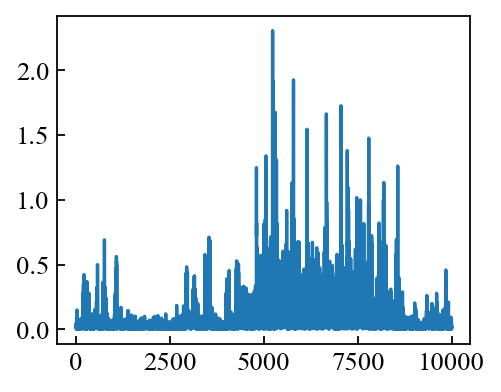

In [103]:
# 绘图
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}
# 画板设置
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)

# 绘图曲线
h = 0
ax.plot(np.arange(1,mape.shape[0]+1), mape[:,h], color=color_list[1], linestyle='-')


# 图例 图标设置

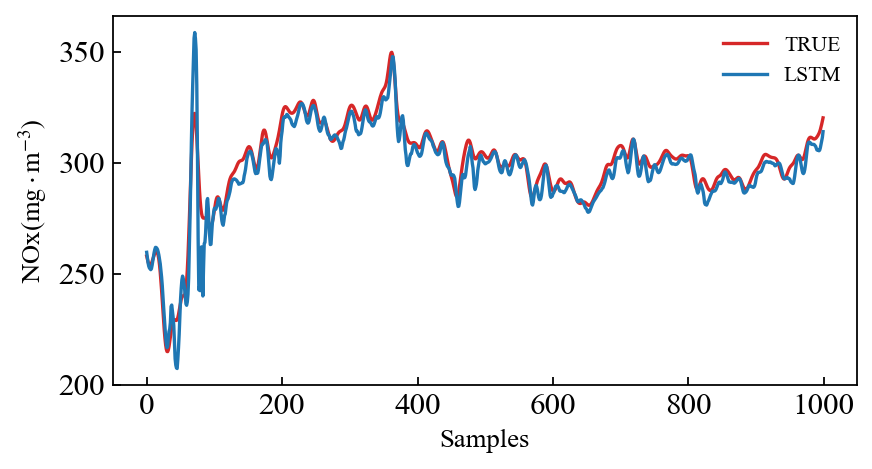

In [109]:
## 画图
## 画图
config = {
"font.family":"times new roman",    
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
    
"ytick.direction":"in",
}
rcParams.update(config)

h = 5
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
plt.figure(dpi=160, figsize=(6,3))
plt.plot(y_true[1000:2000,h],color = color_list[4],linewidth=1.5)
plt.plot(y_pred[1000:2000,h],color = color_list[0],linewidth=1.5)


plt.xlabel("Samples",{"size":12})
plt.ylabel("NOx($\mathrm{mg \cdot m^{-3}}$)",{"size":12})
plt.legend(['TRUE', 'LSTM'],frameon=False, fontsize = 'x-small',bbox_to_anchor=(1.005, 1) )

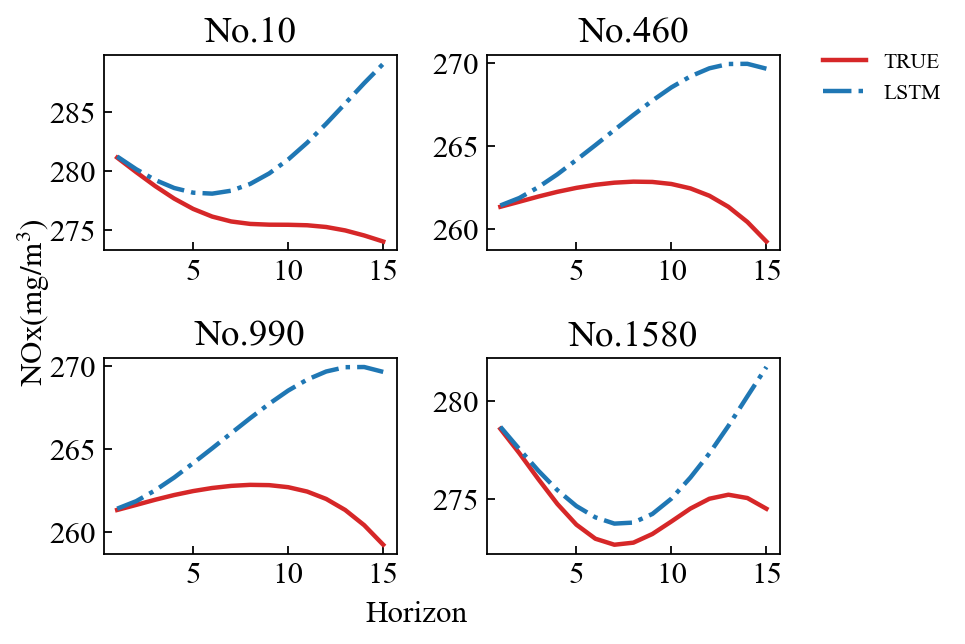

In [114]:
config = {
"font.family":'serif',  
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
x = np.arange(1,16)
fig, ax1 = plt.subplots(2,2, figsize=(5,4), dpi=160)


point = 100
ax1[0,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,0].set_title('No.10')


point = 400
ax1[0,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,1].set_title('No.460')

point = 400
ax1[1,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,0].set_title('No.990')

point = 900   # 1380
ax1[1,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,1].set_title('No.1580')
#ax1[1,1].set_ylim([290,320])

egend_font = {"family" : "serif"}
fig.legend(['TRUE', 'LSTM', ],frameon=False,\
           fontsize='x-small', bbox_to_anchor=(1.18, 0.92))

fig.text(0.5, 0, "Horizon", ha='center')
fig.text(0, 0.5, "NOx($\mathrm{mg/m^{3}}$)", va='center', rotation='vertical')   
plt.tight_layout()